In [1]:
#titanic에서 데이터 분석한 결과를 가지고 데이터를 전처리 한후 LightGBM를 사용해서 예측률을 높여본다.
# LightGBM에서 하이퍼파라미터를 어떻게 조정할지에 대한 방법을 연습한다.
# Bayesian Optimization를 적용
# 2020.5.14

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lxgb
from bayes_opt import BayesianOptimization


titanic_data = pd.read_csv('titanic_train.csv')
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
#불필요한 요소 삭제
titanic_data = titanic_data.drop(['PassengerId', 'Name', 'Ticket'], axis = 1)
# cabin정보의 missing을 N으로 선실번호에서 앞자만 사용
titanic_data.Cabin.fillna('N', inplace = True)
titanic_data['H_Cabin'] = titanic_data['Cabin'].apply(lambda x : x[0])
#missing value 처리
#Age는 평균값으로 처리
titanic_data.Age.fillna(titanic_data.Age.mean(), inplace = True)
#Cabin은 삭제하고 H_cabin사용
titanic_data = titanic_data.drop(['Cabin'], axis = 1)
#Embarked는 가장 많은  S로
titanic_data.Embarked.fillna('S', inplace = True)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,H_Cabin
0,0,3,male,22.0,1,0,7.2500,S,N
1,1,1,female,38.0,1,0,71.2833,C,C
2,1,3,female,26.0,0,0,7.9250,S,N
3,1,1,female,35.0,1,0,53.1000,S,C
4,0,3,male,35.0,0,0,8.0500,S,N


In [3]:
# 중요한 요소이긴 하지만 2이상은 데이터가 적어서, 있으면 1 없으면 0으로
titanic_data['SibSp'] = titanic_data['SibSp'].apply(lambda x : 1 if x > 0 else 0)

#분류 값들을 수치값으로 변경
titanic_data.Sex.replace({'male': 0.0, 'female': 1.0}, inplace= True)

#Dependents 값을 get_dummies 함수를 이용해서 수치로 변경 OneHotEncode를 사용해도 된다.
#drop first를 True로 해서 dummy trap을 피한다.
dummies = pd.get_dummies(titanic_data['Embarked'], prefix='Embarked', drop_first=True)
titanic_data = pd.concat([titanic_data, dummies], axis=1)
titanic_data = titanic_data.drop(['Embarked'],  axis=1)

dummies = pd.get_dummies(titanic_data['H_Cabin'], prefix='Cabin', drop_first=True)
titanic_data = pd.concat([titanic_data, dummies], axis=1)
titanic_data = titanic_data.drop(['H_Cabin'],  axis=1)

# 더 많은 column을 보여주도록 변경
pd.set_option('display.max_columns', 100) 
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N,Cabin_T
0,0,3,0.0,22.0,1,0,7.2500,0,1,0,0,0,0,0,0,1,0
1,1,1,1.0,38.0,1,0,71.2833,0,0,0,1,0,0,0,0,0,0
2,1,3,1.0,26.0,0,0,7.9250,0,1,0,0,0,0,0,0,1,0
3,1,1,1.0,35.0,1,0,53.1000,0,1,0,1,0,0,0,0,0,0
4,0,3,0.0,35.0,0,0,8.0500,0,1,0,0,0,0,0,0,1,0


In [4]:
#Test를 위한 데이터 생성
y_data = titanic_data.Survived
x_data = titanic_data.drop('Survived', axis = 1)
#test 와 train set 만들기
X_train, X_test, y_train, y_test= train_test_split(x_data, y_data, test_size=0.2, random_state=123)

In [5]:
# 평가 함수 선언
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))    

In [6]:
lgbm_clf = LGBMClassifier(n_estimators=400, learning_rate=0.1, max_depth=3, device='gpu')
lgbm_clf.fit(X_train, y_train)
w_preds = lgbm_clf.predict(X_test)
w_pred_proba = lgbm_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test , w_preds, w_pred_proba)

LightGBMError: GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1

In [37]:
from sklearn.model_selection import GridSearchCV

param_test1 = { 'max_depth': [3, 5, 7, 9], 'min_child_weight': [1,3,5,7],'gamma':[i/10.0 for i in range(0,5)] } 

lgbm_clf = LGBMClassifier(learning_rate =0.1, n_estimators=140, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, 
                          colsample_bytree=0.8,objective= 'binary', nthread=4, scale_pos_weight=1, seed=27)
gsearch1 = GridSearchCV(lgbm_clf, param_grid = param_test1, scoring='roc_auc', cv=3)
gsearch1.fit(X_train, y_train)

print("최적화 파라미터 :", gsearch1.best_params_)
print("GridSearch_CV 최고정확도: {0:.4f}".format(gsearch1.best_score_))

최적화 파라미터 : {'gamma': 0.0, 'max_depth': 7, 'min_child_weight': 3}
GridSearch_CV 최고정확도: 0.8520


In [39]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

kfold = StratifiedKFold(n_splits=3, random_state=5)
scores = []

def object_function(n_e, l_r, m_d, m_c_w, s_s) :
    lgbm_model = LGBMClassifier(n_estimators=int(round(n_e)), learning_rate=l_r, max_depth=int(round(m_d)), 
                                min_child_weight=int(round(m_c_w)), subsample=s_s)
    results = cross_val_score(lgbm_model, X_train, y_train, cv=kfold, scoring='roc_auc')
    score = results.mean()
    scores.append(score)
    return score

# Bounded region of parameter space
pbounds = {'n_e': (50, 1000), 'l_r': (0.01, 0.2), 'm_d':(1, 10), 'm_c_w':(0,120), 's_s':(0.5,1)}

optimizer1 = BayesianOptimization(
    f=object_function,
    pbounds=pbounds,
    verbose=1, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=3,
)

optimizer1.maximize(
    init_points=3,
    n_iter=50,
)

print(optimizer1.max)

C:\Users\Professor Lee\anaconda3\envs\tf2\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


|   iter    |  target   |    l_r    |   m_c_w   |    m_d    |    n_e    |    s_s    |
-------------------------------------------------------------------------------------
|  2        |  0.8466   |  0.1803   |  15.07    |  2.865    |  98.89    |  0.7204   |
|  18       |  0.8468   |  0.1253   |  11.29    |  3.072    |  97.31    |  0.6749   |
|  34       |  0.8489   |  0.05353  |  0.1432   |  9.482    |  238.0    |  0.9498   |
|  47       |  0.8491   |  0.05716  |  0.2679   |  9.055    |  275.4    |  0.572    |
|  53       |  0.85     |  0.1192   |  9.305    |  9.28     |  243.1    |  0.8058   |
{'target': 0.8499521744504093, 'params': {'l_r': 0.11921363126183525, 'm_c_w': 9.305406346248084, 'm_d': 9.280207866965522, 'n_e': 243.13327487493527, 's_s': 0.8057784593250108}}


Best Grid Xgbm accuracy score:0.8771
오차 행렬
[[103  11]
 [ 11  54]]
정확도: 0.8771, 정밀도: 0.8308, 재현율: 0.8308,    F1: 0.8308, AUC:0.9109
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       114
           1       0.83      0.83      0.83        65

    accuracy                           0.88       179
   macro avg       0.87      0.87      0.87       179
weighted avg       0.88      0.88      0.88       179



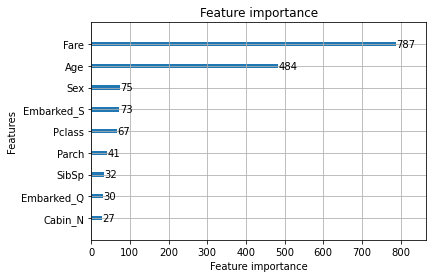

In [20]:
best_lgbm = LGBMClassifier(n_estimators=243, learning_rate=0.11921363126183525, max_depth=9, min_child_weight=9, subsample=0.8057784593250108)
 
best_lgbm.fit(X_train, y_train)
preds = best_lgbm.predict(X_test)
pred_proba = best_lgbm.predict_proba(X_test)[:, 1]

print("Best Grid Xgbm accuracy score:{0:.4f}".format(accuracy_score(y_test,preds)))
get_clf_eval(y_test , preds, pred_proba)
print(classification_report(y_test, preds))
lxgb.plot_importance(best_lgbm)

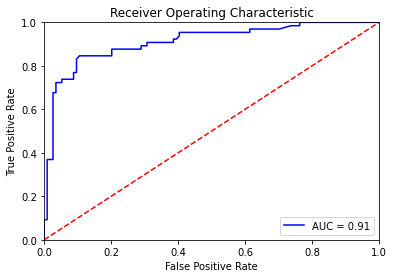

In [21]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, pred_proba)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [27]:
from numba import jit
import numpy as np 
# to measure exec time 
from timeit import default_timer as timer    

# normal function to run on cpu 
def func(a):                                 
    for i in range(10000000): 
        a[i]+= 1      

# function optimized to run on gpu  
@jit
#(target ="cuda")                          
def func2(a): 
    for i in range(10000000): 
        a[i]+= 1
if __name__=="__main__": 
    n = 10000000                            
    a = np.ones(n, dtype = np.float64) 
    b = np.ones(n, dtype = np.float32) 

    start = timer() 
    func(a) 
    print("without GPU:", timer()-start)     

    start = timer() 
    func2(a) 
    print("with GPU:", timer()-start) 

without GPU: 3.6672838000013144
with GPU: 0.13291039999967325
